# Movie reviews

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Movie reviews. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")

    X_quant_features = movie_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [4]:
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='moviereviews_train.tsv', my_random_seed=2000)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         433          20
1         158          16
2         378          20
3         379           8
4         367           9


# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [5]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 9957, 'Neg': 10043, 'TP': 4817, 'TN': 5384, 'FP': 4659, 'FN': 5140, 'Accuracy': 0.51005, 'Precision': 0.5083368509919798, 'Recall': 0.48378025509691674, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [6]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 9957, 'Neg': 10043, 'TP': 9957, 'TN': 10043, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_train'}


### MODEL: logistic regression

In [7]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 9957, 'Neg': 10043, 'TP': 9957, 'TN': 10043, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [8]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 9957, 'Neg': 10043, 'TP': 9550, 'TN': 9876, 'FP': 167, 'FN': 407, 'Accuracy': 0.9713, 'Precision': 0.9828136256046105, 'Recall': 0.9591242342070905, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [9]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 9957, 'Neg': 10043, 'TP': 9957, 'TN': 10043, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

class sklearn.linear_model.RidgeClassifier(alpha=1.0, fit_intercept=True, normalize=False, copy_X=True, max_iter=None, tol=0.001, class_weight=None, solver='auto', random_state=None)

alpha reduces variance, fit_intercept calc the intercept(?), normalize will normalize before regression, copy_x, max_iter number of iterations, tol is the precision of the solution, class weight will change the weights of classes, solver uses different algorithms in computational routines.

In [10]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=.3, tol=0.05, class_weight='balanced', solver='sag')
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 9957, 'Neg': 10043, 'TP': 9859, 'TN': 9928, 'FP': 115, 'FN': 98, 'Accuracy': 0.98935, 'Precision': 0.9884700220573491, 'Recall': 0.9901576780154665, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [11]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=50, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'Pos': 9957, 'Neg': 10043, 'TP': 9734, 'TN': 9619, 'FP': 424, 'FN': 223, 'Accuracy': 0.96765, 'Precision': 0.9582594999015555, 'Recall': 0.9776036958923371, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

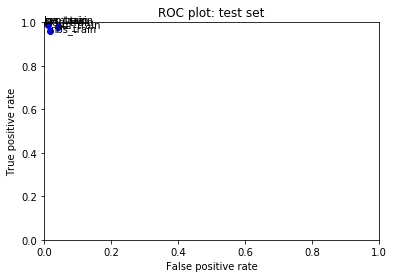

In [12]:
fits = [svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [13]:
ols_predictions = ols.predict(X_train)

### let's look at some false positives:

In [14]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:
81
This movie is not as good as all the movies of Christ I've ever seen. And I'm quite amazed that in this story Pilate wants to finish Jesus, when the Scriptures (as well the other movies) state differently. It lacks also a very important issue: The Resurrection.. None of the other movies skip this very important part: the faith of all of us Christians lies in this very event. As Paul says in one of his letters \If Christ did not rise from the dead, our faith is vain\". A very impressive scene for me in this movie was seeing on the streets the remains of the palms that were used when Jesus entered Jerusalem. <br /><br />Finally, and in opposition to my Jewish co-commentator, Jesus WAS NOT a myth. And as a matter of fact, he was also a JEW. There are plenty of documents (relgious and secular) that prove the existence of this extraordinary man(or should I said, God become a man) that indeed changed mankind. I strongly advise him(given he is a historian) to r

817
I didn't even know this was originally a made-for-tv movie when I saw it, but I guessed it through the running time. It has the same washed-out colors, bland characters, and horrible synthesized music that I remember from the 80's, plus a 'social platform' that practically screams \Afterschool special\". Anyhoo.<br /><br />Rona Jaffe's (thank you) Mazes and Monsters was made in the heyday of Dungeons & Dragons, a pen-and-paper RPG that took the hearts of millions of geeks around America. I count myself one of said geeks, tho I have never played D&D specifically I have dabbled in one of its brethren. M&M was also made in the heyday of D&D's major controversy-that it was so engrossing that people could lose touch with reality, be worshiping Satan without knowing, blah blah. I suppose it was a legitimate concern at one point, if extremely rare-but it dates this movie horrendously.<br /><br />We meet 4 young college students, who play the aptly named Mazes and Monsters, to socialize an

3386
I can't even believe that this show lasted as long as it did. I guess it's all part of the dumbing down of America. Personally, like David Spade said, I liked this show better when it went by its original title - \Seinfeld\". What bothers me the most about this show, aside from the obvious, base sense of \"humor\", and general smuttiness, is the pretentious way the episodes are titled. Truly great shows are still funny after many, repeated viewings, like, \"the one where Rob gets accidentally hypnotized\", on the \"Dick Van Dyke Show\", or \"the one where Lucy and Ethel work at the candy factory.\" In other words, it's an honor bestowed upon great programs by the viewers. That the writers and producers of \"Friends\" would have the unmitigated hubris to actually title the episodes, themselves, in such a fashion, before anyone's even had a chance to even see it a second time, speaks to not only the mediocrity and lack of original thinking on the part of said writers, but, also, of 

6587
Unentertaining, uninvolving hybrid of \Cruel Intentions\" and \"Wild Things\", but it isn't nearly as good as either of those trash min-classics. It's about the acting sheriff, Artie (Taye Diggs) being called in to investigate a near-fatal drug overdose at a posh upper-class Univesity, but to keep it on the down low. As he digs deeper he thinks it's much more than it at first glance seems to be. We follow Alicia, the girl who overdosed in flashbacks as well. At about 90 minutes, if this film was welcomed to begin with, it would have worn it out. This film brings absolutely nothing new to the table. But it IS the only movie thus far that has Miss Swain topless so the grade is higher just for that.<br /><br />My Grade: D<br /><br />Eye Candy: Dominique Swain gets topless( fixing a mistake of \"Happy Campers\"); another girl is topless <br /><br />Anti-Eye candy: more men ass than girl tit"
* * * * * * * * * 
6946
In one word: excruciating. I was advised to read some articles about t

9574
The movie is steeped in religion, so it is impossible to separate it from religion in commenting upon it. In my opinion, this movie pretends to explore deep issues, but thrives on stereotypes and prejudices; with little true insight. What the people in the movie (and therefore, the writer) failed to see was grace. They failed to understand that God is the author of beauty and He is the Creator of passion and sexual gratification in the proper context of marriage bonds. To imply that the people of the society in which the story is based believe that nudity is sinful, and both the man & the woman enjoying the act of marriage is dirty, is just an oversimplification. Such stereotypes really don't exist, for even Jewish holy writings speak clearly of the caring husband who will seek his wife's pleasure before his own. Scripture says that a man ought to love his wife as his own flesh, and that no man ever hated his own flesh, but he nourishes and cherishes it. Even if you want to ignore

11373
Fred Olen Ray is a lousy director, even as far as B movie directors go, but 'Haunting Fear' is probably one of his better films. Yes, it does butcher the great Poe story 'Premature Burial' and yes, it is badly paced and uneven throughout, but it is also pretty entertaining. Scream Queen Brinke Stevens is better than usual as a pretty, fragile housewife whose worthless husband (Jay Richardson) is plotting to do away with her because he needs money to pay off a gangster (played by Robert Quarry). Delia Sheppard, a veteran of many early 90s soft-core movies, actually gives the best performance in the film as a slutty mistress. You will also enjoy small roles played by Karen Black as a psychic, Robert Clarke as a doctor and Michael Berryman in a nice cameo in one of the better scenes. The ending didn't make much sense!
* * * * * * * * * 
11786
This movie, no correction, this THING, this abysmal abomination from the burning pits of hell should have been killed before it even left the 

13386
Depending entirely on your own personal state of mind when watching this, \Christmas Evil\" can either turn out to become an ambitious and innovative psychological thriller OR one of the most pathetic and infuriatingly lame holiday-themed slashers ever made. Me, personally, I'm tempted to opt for the latter because I didn't bother to do any research at all and simply anticipated a cheesy and undemanding early 80's slasher with a nutcase in a Santa Clause costume butchering people. Wrong! The movie actually handles about a bloke named Harry Stadling; who's obsessed with Christmas, works in a rubbish toy factory and considers it to be his responsibility to determine on Christmas Eve who deserves presents and who deserves punishment. Harry's issues all started when he witnessed Santa  his daddy in a costume obviously  caress his mommy's naked legs at a tenderly young age. After that he just developed into a social outcast, much to the irritation of his younger brother, who's bound

14506
The movie is pretty funny and involving for about four dates, then it becomes a blatant commercial for some guy you (and even his \friends\") really can't stand. It is a pretty interesting concept; film dates on a quest to find true love in modern LA. The problem is that it feels incredibly (and badly) scripted at times and blatantly self-promoting. It is difficult to care about and be drawn into any of the characters because the writer/actor is so egotistical, uncool, untrue, and simply unlikeable. You end up feeling sorry for his dates."
* * * * * * * * * 
14514
\Rois et Reine\" is a sprawling mess of a movie which will probably irritate as many viewers as it delights. It focuses by turns on ex-lovers Nora (Emanuelle Devos)and Ismael (Mathieu Amalric) as they each confront a major crisis in their now separate lives. While Nora's story is played straight and is sombre in tone, Ismael's is played mainly for laughs, although it's not particularly funny. Nora's crisis is triggered 

16354
The potential was there. I saw Creep and thought, 'Oooh, this is getting interesting' several times. Yet somehow the interesting plot lines wound up unexplained or ignored, like they never happened. The lead character was irritating throughout the movie, and at one point my fella and I both shouted that we wanted her to die. There are some genuinely spooky/scary moments, but these are grossly overshadowed by the moments that just annoyed the hell out of me. It's another one of those horror movies that crops up and intrigues you for a while, but ultimately leaves you frustrated and a little confused about what the movie makers were trying to achieve.<br /><br />The one saving grace of this movie is the bad guy, but when the baddie is more likable than the lead character you know you're on to a loser.
* * * * * * * * * 
16409
To the small minority seen here praising this film GET SERIOUS. I know it's down to peoples personal opinion at the end of the day, but anyone with more than 

19300
There are many different versions of this one floating around, so make sure you can locate one of the unrated copies, otherwise some gore and one scene of nudity might be missing. Some versions also omit most of the opening sequence and other bits here and there. The cut I saw has the on-screen title WITCHCRAFT: EVIL ENCOUNTERS and was released by Shriek Show, who maintain the original US release title WITCHERY for the DVD release. It's a nice-looking print and seems to have all of the footage, but has some cropping/aspect ratio issues. In Italy, it was released as LA CASA 4 (WITCHCRAFT). The first two LA CASA releases were actually the first two EVIL DEAD films (retitled) and the third LA CASA was another film by the same production company (Filmirage), which is best known here in America as GHOSTHOUSE. To make matters even more confusing, WITCHERY was also released elsewhere as GHOSTHOUSE 2. Except in Germany, where GHOSTHOUSE 2 is actually THE OGRE: DEMONS 3. OK, I better just

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [15]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 2543, 'Neg': 2457, 'TP': 1197, 'TN': 1339, 'FP': 1118, 'FN': 1346, 'Accuracy': 0.5072, 'Precision': 0.5170626349892009, 'Recall': 0.4707038930397169, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [16]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2543, 'Neg': 2457, 'TP': 2169, 'TN': 2049, 'FP': 408, 'FN': 374, 'Accuracy': 0.8436, 'Precision': 0.8416763678696159, 'Recall': 0.8529296106960284, 'desc': 'svm_test'}


### MODEL: logistic regression

In [17]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2543, 'Neg': 2457, 'TP': 2192, 'TN': 2039, 'FP': 418, 'FN': 351, 'Accuracy': 0.8462, 'Precision': 0.8398467432950192, 'Recall': 0.8619740464018876, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [18]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2543, 'Neg': 2457, 'TP': 1913, 'TN': 1834, 'FP': 623, 'FN': 630, 'Accuracy': 0.7494, 'Precision': 0.7543375394321766, 'Recall': 0.7522611089264648, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [19]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2543, 'Neg': 2457, 'TP': 2141, 'TN': 2049, 'FP': 408, 'FN': 402, 'Accuracy': 0.838, 'Precision': 0.8399372302863868, 'Recall': 0.8419189933149823, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [20]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2543, 'Neg': 2457, 'TP': 2306, 'TN': 2178, 'FP': 279, 'FN': 237, 'Accuracy': 0.8968, 'Precision': 0.8920696324951644, 'Recall': 0.9068029885961463, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [21]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2543, 'Neg': 2457, 'TP': 1885, 'TN': 1796, 'FP': 661, 'FN': 658, 'Accuracy': 0.7362, 'Precision': 0.7403770620581304, 'Recall': 0.7412504915454188, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

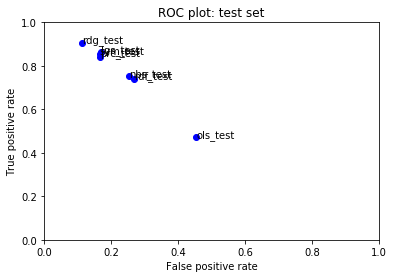

In [22]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [23]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='moviereviews_test.tsv', my_random_seed=200, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         131           5
1         169          15
2         176          18
3         112           5
4         133           8
5         331          20
6         121          18
7         230          22
8          59           3
9         224          14
Size

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [24]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = rdg.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.47644


In [25]:
raw_data.head()

,id,review,word_count,punc_count
0,12311_10,Naturally in a film who's main themes are of m...,131,5
1,8348_2,This movie is a disaster within a disaster fil...,169,15
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,18
3,7186_2,Afraid of the Dark left me with the impression...,112,5
4,12128_7,A very accurate depiction of small time mob li...,133,8


In [26]:
my_submission.head()

,id,prediction
0,12311_10,1
1,8348_2,0
2,5828_4,0
3,7186_2,0
4,12128_7,1


In [27]:
my_submission.shape

(25000, 2)

In [28]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('moviereviews_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation